# Batched Optimization

In this notebook we use boax to walk you through a simple workflow of batched bayesion optimization.

As in the Getting Started guide, we follow the same three steps:
1. Fitting a surrogate model to training data
2. Constructing a acquisition function based on the model's output
3. Selecting the data points with the hightes acquisition scores points for evaluation

In [1]:
from jax import config

config.update("jax_enable_x64", True)

from jax import numpy as jnp
from jax import jit, lax, nn, random, value_and_grad

import optax
import matplotlib.pyplot as plt

plt.style.use('bmh')

from boax import prediction, optimization
from boax.core import distributions, samplers
from boax.prediction import kernels, likelihoods, means, models, objectives
from boax.optimization import acquisitions, optimizers

As part of the environment we initialize two PRNG keys with a starting seed of 0.

In [2]:
data_key, sampler_key, optimizer_key = random.split(random.key(0), 3)

## Defining the latent objective function

In bayesian optimization we treat the objective as an expensive to evaluate black box function. For this example we choose a 2-dimensional function that emulates the mapping of the SVM hyper-parameter space to its accuracy. We aim to maximize this function the interval of `[0, 2]` and `[0, 2]` respectively.

In [3]:
def objective(x):
    return (
        jnp.sin(5 * x[..., 0] / 2 - 2.5)
        * jnp.cos(2.5 - 5 * x[..., 1])
        + (5 * x[..., 1] / 2 + 0.5) ** 2 / 10
    ) / 5 + 0.2

When defining the objective function we expect an input of shape `(n, d)`, where `n` indicates the number of examples in the training set and `d` indicates the number of dimensions for each data point.

In [4]:
bounds = jnp.array([[0.0, 2.0]] * 2)

The bounds are of shape `(d, 2)`, where `d` indicates the number of dimensions, each described by a lower and upper bound.

## Generating training data

In this example we assume to have already evaluated the objective function a random starting point drawn from a uniformly random distribution.

In [5]:
x_train = random.uniform(data_key, minval=bounds[:, 0], maxval=bounds[:, 1], shape=(1, 2))
y_train = objective(x_train)

In the following we plot the observations from the evaluation in the context of the latent objective function.

In [6]:
grid = jnp.linspace(0, 2, 101)
x1, x2 = jnp.meshgrid(grid, grid, indexing="ij")
xs = jnp.vstack((x1.flatten(), x2.flatten())).transpose(-1, -2)
ys = objective(xs)

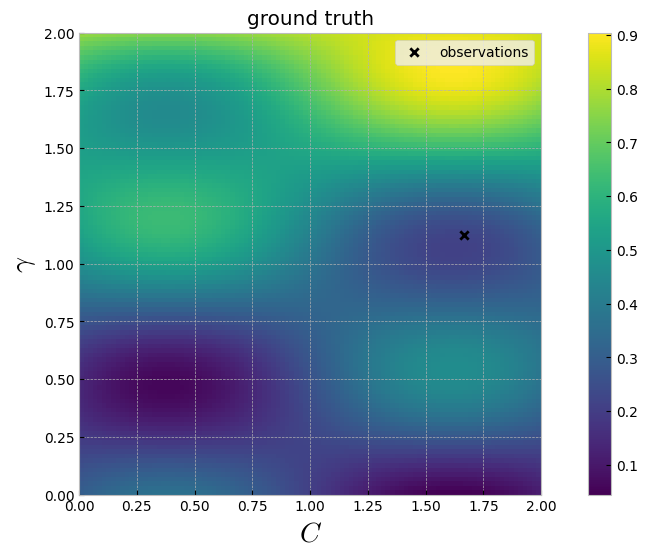

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

c = ax.imshow(ys.reshape(101, 101).T, origin="lower", extent=[0.0, 2.0, 0.0, 2.0])
ax.set_xlabel(r"$C$", fontsize=20)
ax.set_ylabel(r"$\gamma$", fontsize=20)
plt.colorbar(c, ax=ax)

ax.scatter(x_train[..., 0], x_train[..., 1], marker='x', c='k', label='observations')
ax.set_title("ground truth")
ax.legend()

plt.show()

## Fitting a Gaussian Process model to the data

With the observations in place, we can now focus on fitting a Gaussian Process model to the data. We choose a simple setup of Gaussian Process with a constant mean function and a scaled Matérn kernel.

As the first step, we initialize the model's parameters, followed by the definition of the optimizer. Note, the `length_scale` parameter is two dimensional, allowing us to capture the length scales of the input dimensions independently.

In [8]:
params = {
    'mean': jnp.zeros(()),
    'length_scale': jnp.zeros((2,)),
    'amplitude': jnp.zeros(()),
}

In [9]:
adam = optax.adam(0.01)

Next, we define the function of fitting the model to the training data. The process is identical to the standard fitting function.

In [10]:
def fit(x_train, y_train):
    def prior(params):
        return models.outcome_transformed(
            models.gaussian_process(
                means.constant(params['mean']),
                kernels.scaled(
                    kernels.matern_five_halves(params['length_scale']),
                    params['amplitude']
                ),
            ),
            likelihoods.gaussian(1e-4),
        )

    def posterior(params):
        return models.outcome_transformed(
            models.gaussian_process_regression(
                means.constant(params['mean']),
                kernels.scaled(
                    kernels.matern_five_halves(params['length_scale']),
                    params['amplitude']
                ),
            )(
                x_train,
                y_train,
            ),
            likelihoods.gaussian(1e-4),
        )

    def objective(params):
        return objectives.negative_log_likelihood(
            distributions.multivariate_normal.logpdf
        )

    def projection(params):
        return {
            'mean': params['mean'],
            'length_scale': nn.softplus(params['length_scale']),
            'amplitude': nn.softplus(params['amplitude']),
        }

    def step(state, i):
        loss_fn = prediction.construct(prior, objective, projection)
        loss, grads = value_and_grad(loss_fn)(state[0], x_train, y_train)
        updates, opt_state = adam.update(grads, state[1])
        params = optax.apply_updates(state[0], updates)

        return (params, opt_state), loss

    (next_params, _), _ = lax.scan(
        jit(step),
        (params, adam.init(params)),
        jnp.arange(500),
    )

    return posterior(
        projection(next_params)
    )

## Constructing an acquisition function

The next step in the bayesian optimization process is the construction of an acqusition function that guides our decision of selecting a new point to query the latent objective function.

For this example we select the batched Probability Of Improvement (q-POI) acquisition function. We implement this construction function with the help of `optimization.construct` and `optimization.acquisitions`.

In [11]:
def construct(model, best):
    return optimization.construct(
        model,
        acquisitions.q_probability_of_improvement(
            tau=1.0,
            best=1.1 * best,
        ),
    )

## Selecting the next data points to query

With the acquisition function in place we can now implement an optimizer that selects the data points with highest acquisition scores.

For that, we define an optimizer using `optimization.optimizers`. In addition to the acquisition function, these optimizers also depend on a set of starting points for their optimization process. These are generally drawn from a uniform distribution within the given interval. However, instead of drawing IID samples we make use of the `core.samplers` API to draw uniform samples based on the halton sequence for a more uniform coverage of the search space.

In [12]:
x0 = jnp.reshape(
    samplers.halton_uniform(
        distributions.uniform.uniform(bounds[:, 0], bounds[:, 1])
    )(
        random.fold_in(sampler_key, 0),
        100 * 4,
    ),
    (100, 4, -1)
)

In [13]:
def select(key, acqf):
    bfgs = optimizers.bfgs(acqf, bounds, x0, 40)
    candidates = bfgs.init(key)
    next_candidates, values = bfgs.update(candidates)

    next_x = next_candidates[jnp.argmax(values)]
    next_y = objective(next_x)

    return next_x, next_y

## Running the experiment

Finally we have everything setup to run the bayesian optimization loop. In order to better retrace the process we define a final function that visualizes our current believe of the latent objective function and the acquisition function at each step.

In [14]:
def visualize(mean, x_train, next_x):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    c = axs[0].imshow(ys.reshape(101, 101).T, origin='lower', extent=[0.0, 2.0, 0.0, 2.0])
    axs[0].set_xlabel(r'$C$', fontsize=20)
    axs[0].set_ylabel(r'$\gamma$', fontsize=20)
    plt.colorbar(c, ax=axs[0])
    
    axs[0].scatter(x_train[..., 0], x_train[..., 1], marker='x', c='k', label='observations')
    axs[0].set_title('ground truth')
    axs[0].legend(loc='upper left')

    c = axs[1].imshow(mean.reshape(101, 101).T, origin='lower', extent=[0.0, 2.0, 0.0, 2.0])
    axs[1].set_xlabel(r'$C$', fontsize=20)
    plt.colorbar(c, ax=axs[1])
    
    axs[1].scatter(next_x[..., 0], next_x[..., 1], marker='x', c='k', label='next query')
    axs[1].set_title('mean')
    axs[1].legend(loc='upper left')

    plt.show()

The bayesian optimization loop is implemented analogue to the standard loop from the Getting Started guide. Here we run the optimization loop for only 5 rounds, as each loop will query a batch of 4 points each.

In [15]:
base_samples = jnp.reshape(
    samplers.halton_normal()(
        random.fold_in(sampler_key, 1),
        128 * 4,
    ),
    (128, 4)
)

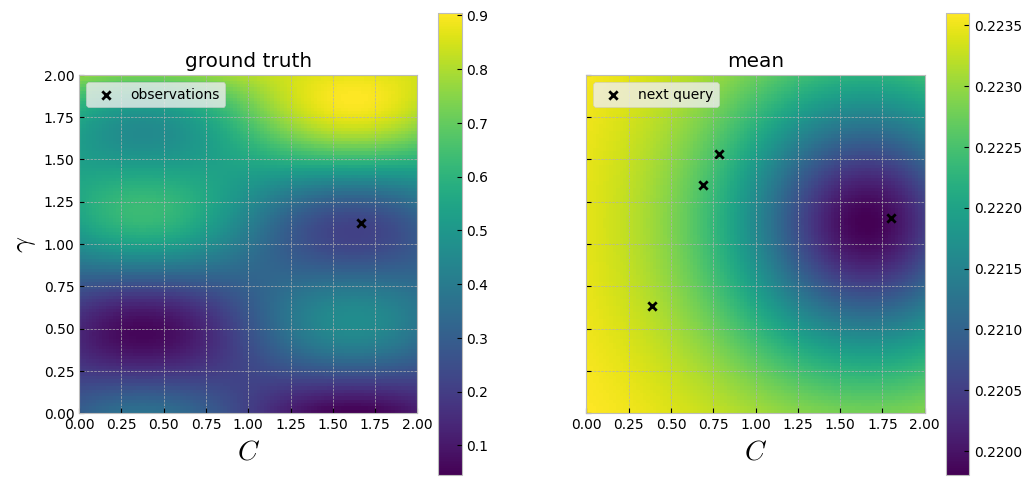

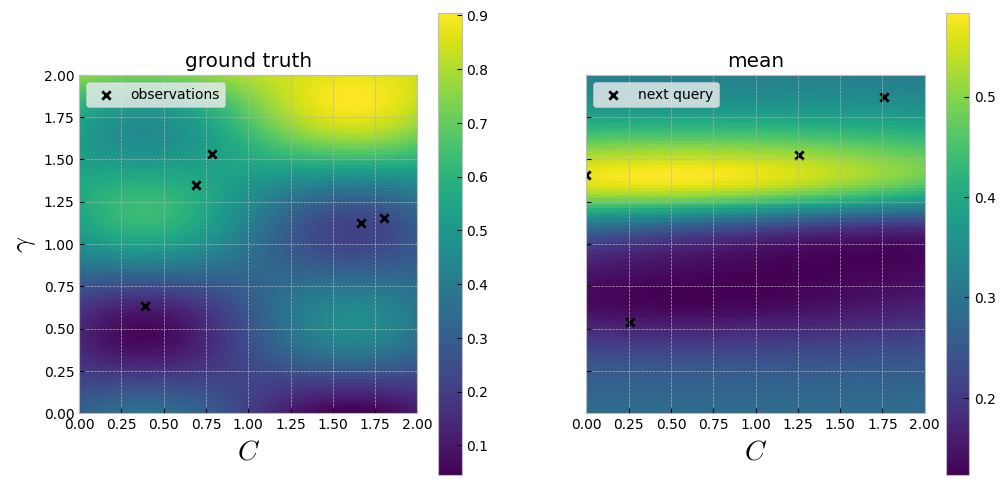

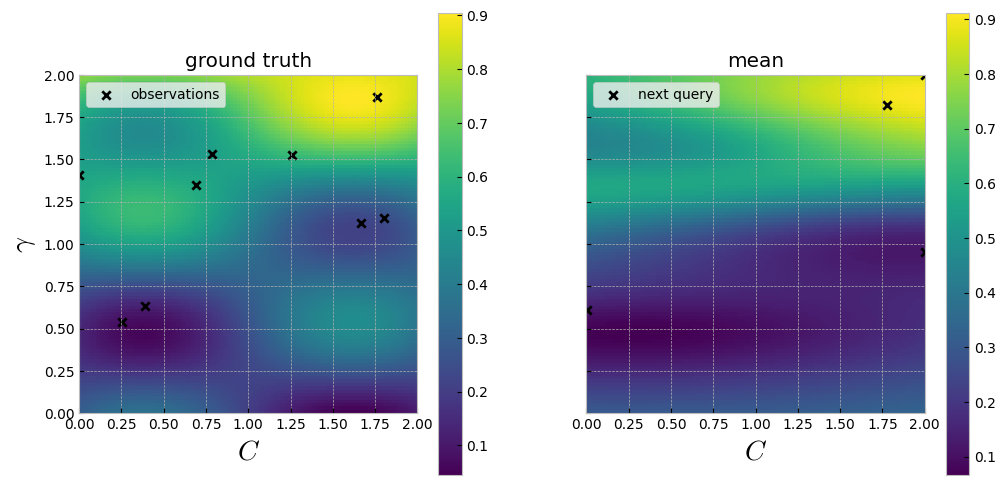

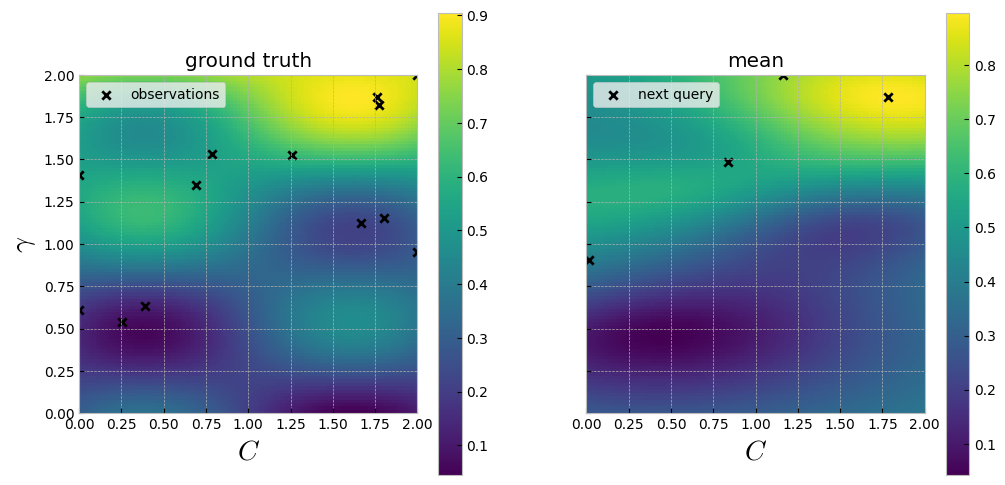

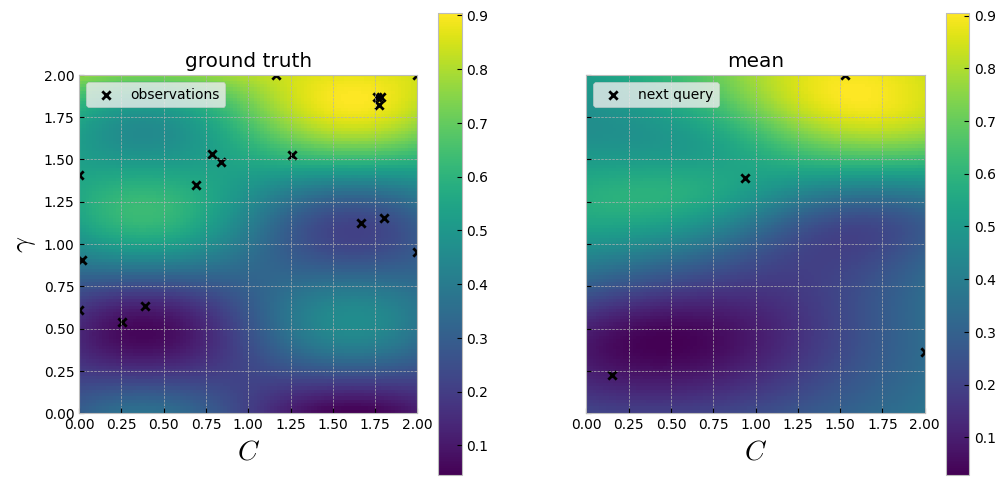

In [16]:
for i in range(5):    
    model = fit(
        x_train,
        y_train,
    )

    acqf = construct(
        models.sampled(
            model,
            distributions.multivariate_normal.sample,
            base_samples
        ),
        jnp.max(y_train),
    )

    next_x, next_y = select(
        random.fold_in(optimizer_key, i),
        acqf
    )

    preds = model(xs)
    
    visualize(preds.mean, x_train, next_x)

    x_train = jnp.vstack([x_train, next_x])
    y_train = jnp.hstack([y_train, next_y])